In [1]:
#Install Dependencies
!pip install stable-baselines3[extra] gymnasium pandas scikit-learn matplotlib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 12.3 MB/s eta 0:00:00


In [2]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import gym
from gym import spaces
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

In [10]:
!pip install shimmy>=2.0 --quiet

In [11]:
# Import shimmy to support OpenAI Gym environments
import shimmy

In [3]:
df = pd.read_csv("/content/ad_bidding_dataset.csv")

In [4]:
df.head()

,timestamp,day,hour,day_of_week,ad_type,website,user_segment,cost,base_ctr,adjusted_ctr,bid_amount,won_auction,impression_served,click_occurred,remaining_daily_budget
0,2023-01-01 00:00:00,0,0,6,banner,blog,seniors,4.30,0.1124,0.1176,0.00,0,0,0,100.00
1,2023-01-01 00:12:00,0,0,6,sidebar,gaming,students,1.74,0.1957,0.1855,1.91,1,1,0,98.26
2,2023-01-01 00:24:00,0,0,6,banner,social,tech_enthusiasts,1.34,0.1439,0.1321,1.48,0,0,0,98.26
3,2023-01-01 00:36:00,0,0,6,native,gaming,students,3.75,0.2053,0.2142,0.00,0,0,0,98.26
4,2023-01-01 00:48:00,0,0,6,popup,social,tech_enthusiasts,5.04,0.1005,0.1054,0.00,0,0,0,98.26


In [5]:
# Encode Categorical Variables

data = df.copy()
label_encoders = {}
categorical_columns = ['ad_type', 'website', 'user_segment']

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

features = ['day', 'hour', 'day_of_week', 'ad_type', 'website', 'user_segment',
            'cost', 'base_ctr', 'adjusted_ctr', 'won_auction',
            'impression_served', 'click_occurred', 'remaining_daily_budget']

In [6]:
# Compute Correlation Weights

correlations = data[features + ['bid_amount']].corr()['bid_amount'].drop('bid_amount')
weights = correlations.abs()
weights /= weights.sum()


In [17]:
# Print the correlation weights
print(weights)

day                       0.003961
hour                      0.003140
day_of_week               0.004268
ad_type                   0.005522
website                   0.011988
user_segment              0.009463
cost                      0.116433
base_ctr                  0.124455
adjusted_ctr              0.125998
won_auction               0.247122
impression_served         0.247122
click_occurred            0.082510
remaining_daily_budget    0.018018
Name: bid_amount, dtype: float64


In [7]:
# Build Weighted State Vector

state_vectors = data[features].multiply(weights, axis=1)
state_vectors['bid_amount'] = data['bid_amount']
state_vectors['website'] = data['website']
state_vectors['click_occurred'] = data['click_occurred']  # For Evaluation

In [8]:
# Define Custom OpenAI Gym Environment

class AdBiddingEnv(gym.Env):
    def __init__(self, df, website_id=0):
        super(AdBiddingEnv, self).__init__()

        self.df = df[df['website'] == website_id].reset_index(drop=True)
        self.n_samples = len(self.df)

        self.state_data = self.df.drop(columns=['bid_amount', 'website', 'click_occurred'])
        self.action_space = spaces.Box(low=0, high=10, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.state_data.shape[1],), dtype=np.float32)

        self.current_step = 0
        self.total_clicks = 0

    def reset(self):
        self.current_step = 0
        self.total_clicks = 0
        return self.state_data.iloc[self.current_step].values.astype(np.float32)

    def step(self, action):
        action = float(action[0])
        actual_bid = self.df.loc[self.current_step, 'bid_amount']
        click = self.df.loc[self.current_step, 'click_occurred']
        reward = 0

        if action >= actual_bid:
            reward = click * (1.0 - abs(action - actual_bid))

        self.total_clicks += click
        self.current_step += 1
        done = self.current_step >= self.n_samples

        if not done:
            next_state = self.state_data.iloc[self.current_step].values.astype(np.float32)
        else:
            next_state = np.zeros_like(self.state_data.iloc[0].values)

        return next_state, reward, done, {}

    def render(self):
        print(f"Step: {self.current_step}, Total Clicks: {self.total_clicks}")

In [13]:
# Train PPO on Each Website

website_labels = label_encoders['website'].classes_
clicks_per_website = {}

for website_id, website_name in enumerate(website_labels):
    print(f"\nTraining PPO for Website: {website_name} (ID: {website_id})")

    env = AdBiddingEnv(state_vectors, website_id)
    model = PPO("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=50000)

    # Evaluation
    obs = env.reset()
    done = False
    clicks = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
    clicks_per_website[website_name] = env.total_clicks
    print(f"Total Clicks: {env.total_clicks}")



Training PPO for Website: blog (ID: 0)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Clicks: 10

Training PPO for Website: entertainment (ID: 1)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Clicks: 16

Training PPO for Website: gaming (ID: 2)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Clicks: 19

Training PPO for Website: news (ID: 3)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Clicks: 10

Training PPO for Website: shopping (ID: 4)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Clicks: 18

Training PPO for Website: social (ID: 5)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Clicks: 7


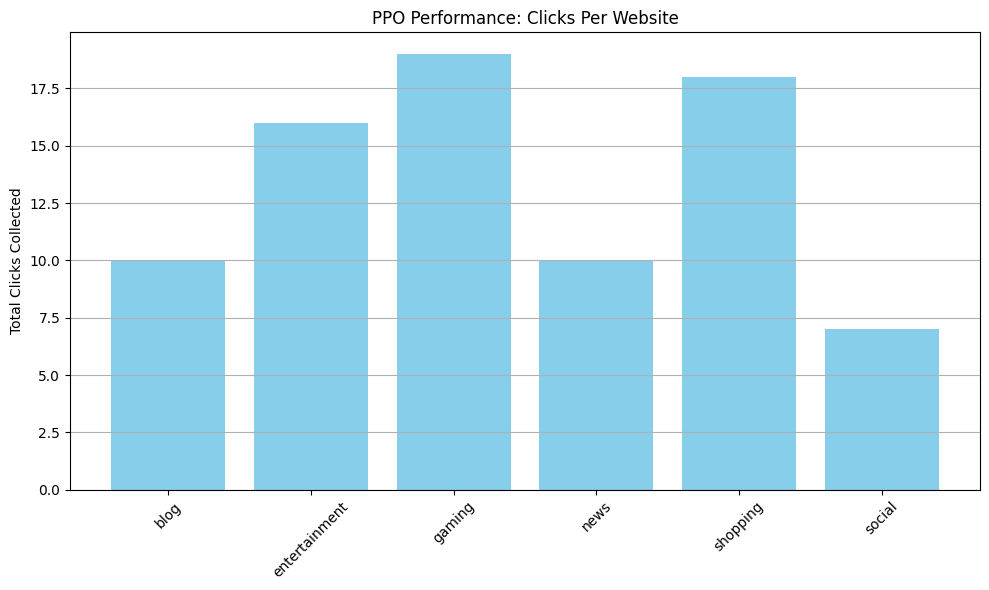

In [14]:
# Plot Clicks Per Website

plt.figure(figsize=(10,6))
plt.bar(clicks_per_website.keys(), clicks_per_website.values(), color='skyblue')
plt.ylabel("Total Clicks Collected")
plt.title("PPO Performance: Clicks Per Website")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [15]:
from collections import Counter

optimal_bids = {}

for website_id, website_name in enumerate(website_labels):
    print(f"\nEvaluating Optimal Bids for: {website_name}")

    env = AdBiddingEnv(state_vectors, website_id)
    model = PPO("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=50000)

    obs = env.reset()
    done = False
    bid_history = []

    while not done:
        action, _ = model.predict(obs)
        bid = float(action[0])
        bid_history.append(round(bid, 2))
        obs, reward, done, _ = env.step(action)

    avg_bid = round(np.mean(bid_history), 2)
    most_common_bid = Counter(bid_history).most_common(1)[0]

    optimal_bids[website_name] = {
        "Average_Bid": avg_bid,
        "Most_Frequent_Bid": most_common_bid[0],
        "Frequency": most_common_bid[1],
    }



Evaluating Optimal Bids for: blog


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



Evaluating Optimal Bids for: entertainment


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



Evaluating Optimal Bids for: gaming


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



Evaluating Optimal Bids for: news


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



Evaluating Optimal Bids for: shopping


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



Evaluating Optimal Bids for: social


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [16]:
# Display Optimal Bidding Amount for each Website
import pandas as pd
optimal_bids_df = pd.DataFrame(optimal_bids).T
print("\nOptimal Bidding Strategy per Website:\n")
display(optimal_bids_df)


Optimal Bidding Strategy per Website:



,Average_Bid,Most_Frequent_Bid,Frequency
blog,0.41,0.0,291.0
entertainment,0.69,0.0,137.0
gaming,0.77,0.0,126.0
news,0.50,0.0,251.0
shopping,0.51,0.0,250.0
social,0.65,0.0,204.0
